# Modelagem do *dataset* de competição do Kaggle "House Prices - Advanced Regression Techniques"

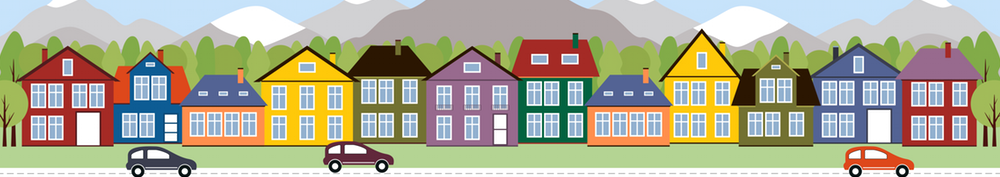

# 1 Resumo

Esta é a segunda parte do projeto relacionado ao *dataset* de competição do Kaggle "House Prices - Advanced Regression Techniques", que teve como objetivos:

1. Analisar e comparar o desempenho de 4 modelos de Machine Learning (Regressão Linear, Random Forest Regressor, KNN Regressor e Support Vector Regression).  

2. Otimizar cada modelo através do *tuning* dos respectivos hiperparâmetros, analisando de que forma eles impactam no desempenho.  

3. Utilizar a técnica de *Stacking Generalization*, para combinar todas as predições de forma a encontrar um modelo cujo desempenho supere todos os outros modelos individualmente.  

Para a Análise Exploratória de Dados completa, clique [aqui](https://hermannvargens.github.io/advaced_regression_houses/).

# 2 Aquisição dos dados

In [1]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
pd.set_option('display.max_columns', 81)

In [3]:
train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Projetos/Advanced Houses/train.csv')
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


Como nesta competição oss envios são avaliados em Root-Mean-Squared-Error (RMSE) entre o logaritmo do valor previsto e o logaritmo do preço de venda observado, vamos desde já fazer a transformação da variável target, usando a função log1p do Numpy:

In [4]:
y = np.log1p(train['SalePrice'])
X = train.drop(columns=['Id','SalePrice'])

# 3 Pré-processamento

Para facilitar a etapa de pré-processamento, vamos separar as colunas em dois tipos, numéricas e categóricas, uma vez que cada um demana diferentes transformações.

## 3.1 Tipos de dados

In [5]:
types = pd.DataFrame(X.dtypes).T
types

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,int64,object,float64,int64,object,object,object,object,object,object,object,object,object,object,object,object,int64,int64,int64,int64,object,object,object,object,object,float64,object,object,object,object,object,object,object,int64,object,int64,int64,int64,object,object,object,object,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,object,int64,object,int64,object,object,float64,object,int64,int64,object,object,object,int64,int64,int64,int64,int64,int64,object,object,object,int64,int64,int64,object,object


Precisamos corrigir os tipos de algumas colunas, de acordo com as descrições disponíveis na competição:

In [6]:
X['MSSubClass'] = X['MSSubClass'].astype(object)

In [7]:
var_cat =[]
var_num =[]

for col in X.columns:
  if X[col].dtypes == object:
    var_cat.append(col)
  else:
    var_num.append(col)
print(f"Há {len(var_cat)} variáveis categóricas ('object'): \n {var_cat}\n")
print(f"Há {len(var_num)} varáveis numéricas ('int64 e float 64'): \n {var_num}")

Há 44 variáveis categóricas ('object'): 
 ['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']

Há 35 varáveis numéricas ('int64 e float 64'): 
 ['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', '

## 3.2 Missing values

Vamos agora passar a etapa de dados ausentes:

In [8]:
pd.DataFrame(X.isna().sum()/X.shape[0]).sort_values(by=0, ascending=False).T

,PoolQC,MiscFeature,Alley,Fence,FireplaceQu,LotFrontage,GarageType,GarageYrBlt,GarageQual,GarageCond,GarageFinish,BsmtFinType2,BsmtExposure,BsmtCond,BsmtFinType1,BsmtQual,MasVnrArea,MasVnrType,Electrical,BedroomAbvGr,BsmtHalfBath,FullBath,KitchenAbvGr,HalfBath,Functional,Fireplaces,KitchenQual,TotRmsAbvGrd,MSSubClass,GrLivArea,GarageCars,GarageArea,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,BsmtFullBath,HeatingQC,LowQualFinSF,Neighborhood,OverallCond,OverallQual,HouseStyle,BldgType,Condition2,Condition1,LandSlope,2ndFlrSF,LotConfig,Utilities,LandContour,LotShape,Street,LotArea,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,ExterQual,ExterCond,Foundation,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,MSZoning,CentralAir,1stFlrSF,SaleCondition
0,0.995205,0.963014,0.937671,0.807534,0.472603,0.177397,0.055479,0.055479,0.055479,0.055479,0.055479,0.026027,0.026027,0.025342,0.025342,0.025342,0.005479,0.005479,0.000685,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Vemos que as colunas 'PoolQC',	'MiscFeature',	'Alley',	'Fence' e	FireplaceQu' apresentam grande quantidade de dados ausentes. A descrição do problema nos é informado que 'NA' significa ausência da feature (isto é, "ausência de piscina" para 'PoolQC', pode exemplo), no entanto, não temos o valor 'NA', e sim 'NaN'.  

Para as colunas 'PoolQC',	'MiscFeature',	'Alley',	'Fence', ainda que venhamos a substituir os valores 'NaN' pela string 'NA', essas colunas apresentarão valores **quasi-constantes**, que terão **pouco valor preditivo**. Assim, optamos por removê-las da lista de variavéis a serem utilizadas.

No entanto, para a variável 'FirepplaceQu', optamos por substituir os valores 'NaN' pela string 'NA', ao invés de remover essa feature, pois ela apresenta menos de 50% de valores 'NaN'.

As demais colunas possuem baixo valor de variáveis ausentes e terão esses valores substituídos pela mediana, se variável numérica, ou pela valor mais frequente, se variável categórica.

In [9]:
#Removendo as variáveis com valores quasi-constantes

var_cat.remove('PoolQC')
var_cat.remove('MiscFeature')
var_cat.remove('Alley')
var_cat.remove('Fence')

#Substituindo os valores 'NaN' pela string 'NA'

X['FireplaceQu'].replace(np.NaN,'NA',inplace=True)

## 3.3 Transformação dos dados

Vamos agora redefinir o dataframe de features baseado na exclusão de algumas colunas e pela substituição de NaN por NA na coluna 'FireplaceQu':

In [10]:
X = X[var_cat+var_num]

Vamos agora criar pipelines de transformação usando o ColumnTransformer:

In [11]:
num_trans = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")),
           ("scaler", StandardScaler())
           ]
)

cat_trans = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="most_frequent")),
           ("ohe", OneHotEncoder(drop='first', handle_unknown="ignore"))]
)

preprocessor = ColumnTransformer(
    [("num", num_trans, var_num),
     ("cat", cat_trans, var_cat)
    ]
)

In [12]:
X = preprocessor.fit_transform(X)

# 4 Modelagem

Inicialmente, vamos testar diversos modelos diferentes para selecionar os mais promissores. Em seguida trabalhar na otimização dos melhores e finalmente tentar um ensemble dos modelos usando o método de Stacking.

In [13]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [14]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

Para facilitar, vamos criar uma função para obter os modelos, uma outra para avaliá-los usando Validação Cruzada e outra função para gerar gráficos boxplot onde será possível comparar visuamente o desempenho de cada um. Testaremos os modelos de Regressão Linear, Random Forest Regressor, K-Nearest Neighbors Regressor e Support Vector Regressor.

In [15]:
#criando uma lista de modelos para avaliação

def get_models():

  models = dict()
  models['lr'] = LinearRegression()
  models['rfr'] = RandomForestRegressor(random_state=0)
  models['knn'] = KNeighborsRegressor()
  models['svr'] = SVR()

  return models

#avaliando cada modelo usando cross-validation

def evaluate_model(model, X, y):
  cv = KFold(n_splits=5, random_state=0, shuffle=True)
  scores = -cross_val_score(model, X, y, scoring = "neg_root_mean_squared_error",cv=cv)
  
  return scores

#gerando gráficos para comparação visual do desempenho

def graph():
  g = sns.boxplot(data=results)
  g.set_xticklabels(names)
  g.set_xlabel("Modelo")
  g.set_ylabel("RMSE")
  plt.show()

In [16]:
#obtendo os modelos

models = get_models()

#avaliando os modelos

results, names = list(), list()

for name, model in models.items():
  scores = evaluate_model(model, X, y)
  results.append(scores)
  names.append(name)
  print('%s = %.5f (%.5f)' % (name, np.mean(scores), np.std(scores)))

lr = 0.20495 (0.02186)
rfr = 0.14340 (0.01834)
knn = 0.17359 (0.02001)
svr = 0.14246 (0.02211)


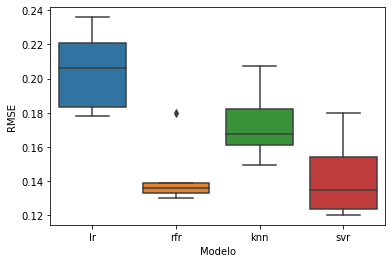

In [17]:
graph()

Vamos trabalhar a partir de agora na otimização de cada modelo separadamente.

# 5 Otimização

## 5.1 Feature Engineering

 Parte do desempenho dos modelos está relacionada com o tipo de de distribuição das variáveis (para ver mais, acesse a EDA [aqui](https://hermannvargens.github.io/advaced_regression_houses/)). Assim, vamos aplicar transformação logarítimica àquelas variáveis numéricas que apresentarem skew>0.5 (em valores absolutos), a fim de de diminuir as assimetrias.

In [18]:
y = np.log1p(train['SalePrice'])
X = train.drop(columns=['Id','SalePrice'])

Como exemplo do que queremos mostrar, observe as duas distribuições abaixo da coluna 'LotFrontage'. À esquerda, está a distribuição dos dados na sua forma original. À direita, a mesma distribuição com o logarítmo dos valores. Pode-se constatar que a forma da distribuição "tornou-se mais normal".

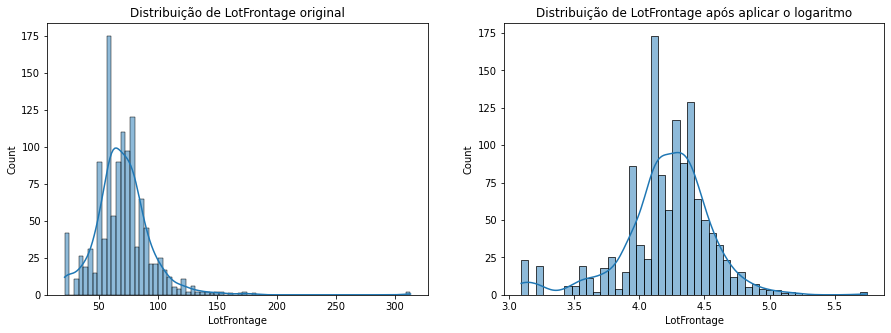

In [19]:
fig, ax = plt.subplots(1,2,figsize=(15,5))
sns.histplot(train['LotFrontage'],kde=True, ax=ax[0]).set_title('Distribuição de LotFrontage original')
sns.histplot(np.log1p(train['LotFrontage']),kde=True,ax=ax[1]).set_title('Distribuição de LotFrontage após aplicar o logaritmo')
plt.show()


Prosseguimos, então, com a tranformação logarítmica das colunas com alta assimetria.

In [20]:
skewed = X[var_num].skew().abs()
skewed = skewed[(skewed>0.5)].sort_values(ascending=False)
skewed

MiscVal          24.476794
PoolArea         14.828374
LotArea          12.207688
3SsnPorch        10.304342
LowQualFinSF      9.011341
KitchenAbvGr      4.488397
BsmtFinSF2        4.255261
ScreenPorch       4.122214
BsmtHalfBath      4.103403
EnclosedPorch     3.089872
MasVnrArea        2.669084
OpenPorchSF       2.364342
LotFrontage       2.163569
BsmtFinSF1        1.685503
WoodDeckSF        1.541376
TotalBsmtSF       1.524255
1stFlrSF          1.376757
GrLivArea         1.366560
BsmtUnfSF         0.920268
2ndFlrSF          0.813030
OverallCond       0.693067
TotRmsAbvGrd      0.676341
HalfBath          0.675897
Fireplaces        0.649565
GarageYrBlt       0.649415
YearBuilt         0.613461
BsmtFullBath      0.596067
YearRemodAdd      0.503562
dtype: float64

In [21]:
X[skewed.index] = np.log1p(X[skewed.index])

## 5.2 Transformação dos dados

Vamos novamente substituir os valores NaN por NA.

In [22]:
X['FireplaceQu'].replace(np.NaN,'NA',inplace=True)

E redefinir o dataframe X a partir das variáveis que foram removidas:

In [23]:
X = X[var_cat+var_num]

In [24]:
X.shape

(1460, 75)

Chamamos novamente a transformação das variáveis usando o Column Transformer:

In [25]:
X = preprocessor.fit_transform(X)

## 5.3 Tuning dos parâmetros

### 5.3.1 Regresão Ridge

Para otimizar a Regressão Linear, vamos empregar o método de regularização de Ridge, mudando o parâmetro 'alpha':

In [26]:
from sklearn.linear_model import Ridge

In [27]:
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 20, 25, 30, 50, 75,100]
rmse_ridge = [evaluate_model(Ridge(alpha = alpha), X, y).mean() for alpha in alphas]

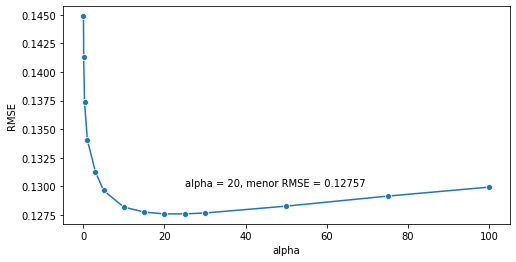

In [28]:
plt.figure(figsize=(8,4))
sns.lineplot(x=alphas, y=rmse_ridge, marker='o')
plt.xlabel("alpha")
plt.ylabel("RMSE")
plt.text(25,0.130, f'alpha = {alphas[-6]}, menor RMSE = {min(rmse_ridge):.5}')
plt.show()

Apenas otimizando o hiperparâmetro 'alpha', conseguimos melhorar o desempenho do modelo, diminuindo o RMSE de 0.20495 para 0.12757!

### 5.3.2 Regressão Lasso

Tentaremos otimizar a Regressão Linear empregando a regularização Lasso:

In [29]:
from sklearn import linear_model

In [30]:
alphas = [0.0001,0.0002,0.0003,0.0004,0.0005,0.00075,0.00085,0.001,0.0015,0.0020]
rmse_lasso = [evaluate_model(linear_model.Lasso(alpha=alpha), X, y).mean() for alpha in alphas]

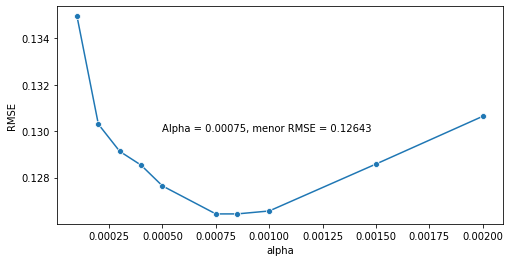

In [31]:
plt.figure(figsize=(8,4))
sns.lineplot(x=alphas, y=rmse_lasso, marker='o')
plt.xlabel("alpha")
plt.ylabel("RMSE")
plt.text(0.0005,0.13, f'Alpha = {alphas[-5]}, menor RMSE = {min(rmse_lasso):.5}')
plt.show()

Vemos que a Regressão Lasso encontrou valores ainda menores que a Regressão Ridge (RMSE=0.12643).

### 5.3.3 Random Forest Regressor

Optamos por não tentar otimizar o modelo Random Forest Regressor.

### 5.3.4 KNN regressor

Para melhorar o modelo KNN, vamos avaliar como o parâmetro 'n' impacta no RMSE do modelo.

In [32]:
from sklearn.neighbors import KNeighborsRegressor

In [33]:
n_neighbors = [2,3,4,5,6,7,8,9,10,20,30,40,50]
rmse_knn = [evaluate_model(KNeighborsRegressor(n_neighbors=n, weights='distance'),X,y).mean() for n in n_neighbors]

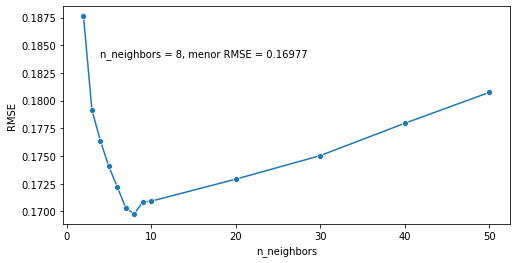

In [34]:
plt.figure(figsize=(8,4))
sns.lineplot(x=n_neighbors, y=rmse_knn, marker='o')
plt.xlabel("n_neighbors")
plt.ylabel("RMSE")
plt.text(4,0.184, f'n_neighbors = {n_neighbors[6]}, menor RMSE = {min(rmse_knn):.5}')
plt.show()

O modelo KNN obteve RMSE = 0.16977.

### 5.3.5 Support Vector Regression

Para otimizar o modelo SVR, vamos analisar como RMSE varia em função dos parâmetros C e epsilon.

In [35]:
from sklearn.svm import SVR

In [36]:
Cs = [0.05,0.5,0.6,0.7,0.8,0.9,1,4]
eps = [0.0001,0.001,0.005,0.010,0.015,0.020,0.040]

table = pd.DataFrame(columns=['C','epsilon','RMSE'])
for C in Cs:
  for e in eps:
    rmse = evaluate_model(SVR(C=C, epsilon=e),X,y).mean()
        
    table = table.append({'C':C,'epsilon':e,'RMSE':rmse},ignore_index=True)

Abaixo, as melhores combinações de C e epsilon que minimizam o RMSE:

In [37]:
table.sort_values(by='RMSE').head()

,C,epsilon,RMSE
18,0.6,0.015,0.134012
17,0.6,0.010,0.134021
19,0.6,0.020,0.134092
24,0.7,0.010,0.134097
25,0.7,0.015,0.134107


Podemos também visualizar o comportamento da RMSE em função de C e epsilon através as curvas abaixo:

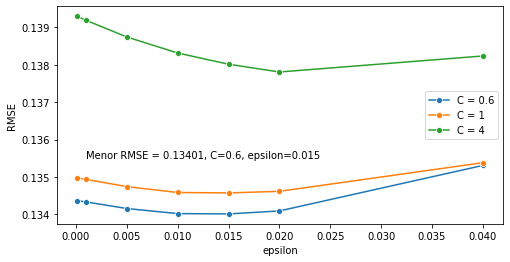

In [38]:
plt.figure(figsize=(8,4))
sns.lineplot(x=table[table['C']==0.6]['epsilon'],y=table[table['C']==0.6]['RMSE'], marker='o')
sns.lineplot(x=table[table['C']==1]['epsilon'],y=table[table['C']==1]['RMSE'], marker='o')
sns.lineplot(x=table[table['C']==4]['epsilon'],y=table[table['C']==4]['RMSE'], marker='o')
plt.legend(labels=['C = 0.6','C = 1','C = 4'])
plt.text(0.001,0.1355,f"Menor RMSE = {table['RMSE'].min():.5}, C=0.6, epsilon=0.015")
plt.show()

Para o Support Vector Machine, vemos que a melhor combinação que diminui o valor de RMSE é C=0.6 e epsilon=0.015 (RMSE = 0.13401).

### 5.3.6 Stacking Generalization 

Para finalizar, vamos construir um modelo Ensemble que combine todos os modelos anteriores e comparar seu desempenho com cada modelo individualmente.  

O tipo de algoritmo 'Stacking Generalization' ou simplesmente 'stacking' (empilhamento) envolve a combinação das predições de diferentes modelos de machine learning (base models), através da utilização de outro modelo (meta model).

In [39]:
from sklearn.ensemble import StackingRegressor

In [40]:
def get_stacking():
  
  #definir os modelos base
  level0 = list()
  level0.append(('ridge', Ridge(alpha = 20)))
  level0.append(('lasso', linear_model.Lasso(alpha=0.00075)))
  level0.append(('rfr', RandomForestRegressor(random_state=0)))
  level0.append(('knn', KNeighborsRegressor(n_neighbors=8, weights='distance')))
  level0.append(('svr', SVR(C=0.6, epsilon=0.015)))
  
  #definir modelo metalearner
  level1 = LinearRegression()
  
  #definir o ensemble stack
  model_stack = StackingRegressor(estimators=level0, final_estimator = level1, cv = 5)

  return model_stack

In [41]:
#Redefinindo a função de obter os modelos para levar em conta o ensemble

def get_models():

  models = dict()
  models['ridge'] = Ridge(alpha = 20)
  models['lasso'] = linear_model.Lasso(alpha = 0.00075)
  models['rfr'] = RandomForestRegressor(random_state=0)
  models['knn'] = KNeighborsRegressor(n_neighbors=8, weights='distance')
  models['svr'] = SVR(C=0.6, epsilon=0.015)
  models['stack'] = get_stacking()

  return models

In [42]:
#obtendo os modelos
models = get_models()

#avaliando os modelos
results, names = list(), list()

for name, model in models.items():
  scores = evaluate_model(model, X, y)
  results.append(scores)
  names.append(name)
  print('RMSE(%s) = %.5f (%.5f)' % (name, np.mean(scores), np.std(scores)))

RMSE(ridge) = 0.12757 (0.02473)
RMSE(lasso) = 0.12643 (0.02487)
RMSE(rfr) = 0.14353 (0.01795)
RMSE(knn) = 0.16977 (0.01739)
RMSE(svr) = 0.13401 (0.02006)
RMSE(stack) = 0.12113 (0.02356)


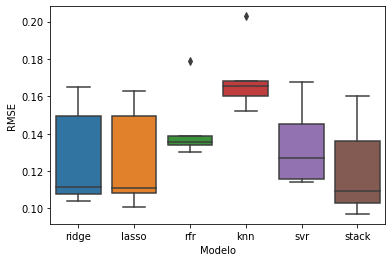

In [43]:
graph()

Comparando os modelos individualmente, concluímos que quando realizamos o stacking, este ensemble é levemente superior a todos os outros, apresentando **RMSE de 0.12113** contra o segundo melhor modelo, Lasso **(RMSE= 0.12643)**. No entanto, ele apresenta um custo computacional mais alto, realizando os cálculos de maneira muito mais demorada, onde numa posterior implentação, seria necessário analisar o trade-off, para **avaliar se compensaria utilizar um modelo como esse.**

# 6 Submissão dos dados de teste

Uma vez que nosso modelo ensemble obteve um desempenho melhor que os outros modelos isoladamente, vamos utilizá-lo para predizer os dados de teste da competição:

In [44]:
#Lendo os dados
test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Projetos/Advanced Houses/test.csv')

#Definimos o dataframe com as features
X_test = test.drop(columns=['Id'])

#Aplicamos o logaritmo nas variáveis com skewd>0.5, conforme tópico 5.1
X_test[skewed.index] = np.log1p(X_test[skewed.index])

#Vamos novamente substituir os valores NaN por NA.
X_test['FireplaceQu'].replace(np.NaN,'NA',inplace=True)
X_test = X_test[var_num+var_cat]

#Aplicamos a transformação dos dados
X_test = preprocessor.transform(X_test)

In [45]:
#Realizamos o ajuste utilizando o modelo Stacking
model_stack = get_stacking()
model_stack.fit(X,y)

#Predizemos os dados de teste
y_test = model_stack.predict(X_test)

In [46]:
#Criamos os dados para submissão

submission_stack = pd.DataFrame()
submission_stack['Id'] = test['Id']
submission_stack['SalePrice'] = np.expm1(y_test)
submission_stack

,Id,SalePrice
0,1461,117578.259435
1,1462,154601.103861
2,1463,184322.369472
3,1464,197057.079360
4,1465,199596.386230
...,...,...
1454,2915,86660.037827
1455,2916,84167.554825
1456,2917,169186.286304
1457,2918,119185.445876


In [47]:
submission_stack.to_csv(index=False)

'Id,SalePrice\n1461,117578.25943534428\n1462,154601.10386109308\n1463,184322.3694721332\n1464,197057.07935951953\n1465,199596.38622976842\n1466,175577.89477671235\n1467,178090.92200392616\n1468,164169.05105159583\n1469,195833.64454858674\n1470,117138.90358118288\n1471,193978.03581511733\n1472,95076.56001656946\n1473,96428.31136743474\n1474,147678.5218468781\n1475,114602.79681061473\n1476,364314.63061858225\n1477,260034.7294382055\n1478,291327.32755789533\n1479,289599.31880385533\n1480,456338.475894588\n1481,338706.8253169904\n1482,219117.15636590595\n1483,179569.6483936275\n1484,166135.07663590115\n1485,193639.76197632134\n1486,197912.3843448395\n1487,336370.2228192486\n1488,239576.78514170198\n1489,199038.10233005273\n1490,226014.1604964759\n1491,195604.8559769749\n1492,88620.87588985468\n1493,189419.63985532295\n1494,297112.12935283006\n1495,298870.19473818265\n1496,235553.9049580433\n1497,179802.40124289668\n1498,162178.59050285688\n1499,160283.23740118445\n1500,157660.56568650083\n

O score obtido na competição foi **0.12191**.

# Conclusão

Neste trabalho, comparou-se o desempenho dos modelos de Regressão Linear, Random Forest Regressor, KNN Regressor e Support Vector Regression, onde, antes da otimização o melhor foi o **Support Vector Regression, como RMSE = 0.14246**. Após a otimização de cada modelo, o menor RMSE foi obtido usando a regularização **Lasso (RMSE = 0.12457)**. Finalmente, temos a superação de todos esses modelos através do **Stacking Regression, que chegou a um RMSE = 0.12113.**  
   
A técnica de empilhamento de diversos modelos, chamada de *Stacking* pode ser eficiente para criar um modelo do tipo ensemble que apresenta desempenho superior a outros modelos isolados. No entanto, isso pode vir a ter um alto custo computacional e o ganho pode não ser tão superior, tornando a sua utilização inviável.  